In [2]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib.pyplot as plt  # For data visualization
%matplotlib inline

nltk.download('stopwords')
nltk.download('punkt')

testTrainSplit = 0.20
usePretrainedModel = False
modelToUse = '80pc-of-5K-percent-trained'
offset = 0
maxRecords = 5000
solution = 'ProfanityDetective'
cleanData = False

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssharma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssharma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Prepare data-set
from nltk.stem.porter import PorterStemmer
import string

ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []

    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    
    return " ".join(y)

if cleanData == True:
    df = pd.read_csv('./dataset/clean_data.csv').head(maxRecords)
    df['transformed_text'] = df['text'].apply(transform_text)
    df.to_csv('./dataset/cleaned-50K.csv', index=False)

In [4]:
df = pd.read_csv('./dataset/clean_data.csv').iloc[offset:offset + maxRecords].head(maxRecords)

In [5]:
styled_df = df.head(5).style
styled_df.set_table_styles([
    {
        "selector": "th",
        "props": [
            ('color', 'black'),
            ('background-color', '#FFEEDD')
        ]
    }
])

,is_profane,text
0,0,Then go to the village pump and suggest they change the language in how a RFC should be set up.
1,1,"ANTI GREEK NATIONALIS -WIKIPEDIA Hi Alexikoua, Yous should not vandalise Wikipedia by editing false information.You may be a chauvinist but you can not edit false information on Wikipedia.There is nowhere 6 percent greeks in Albania. ... THIS IS THE REAL INFORMATION BECAUSE IT IS THE CENSUS. DO NOT VANDALISE WIKIPEDIA WITH YOUR MILITANT IDEAS."
2,1,Dis hoe wasnt dis violent on Lottery Ticket 😂😂
3,0,It is better for Atabay not helping the banned vandals pushing their POV.
4,0,"""is in CamelCase. """"SiCKO"""" is not CamelCase, so the CamelCase rule R. Baley mentions is inapplicable. """


In [6]:
df.rename(columns={'is_profane': 'target'}, inplace=True)
df.dropna(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5000 non-null   int64 
 1   text    5000 non-null   object
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [7]:

df.shape
print(f'Nulls: {df.isnull().sum()}')
print(f'Duplicates: {df.duplicated().sum()}')

Nulls: target    0
text      0
dtype: int64
Duplicates: 0


In [8]:
values = df['target'].value_counts()
total = values.sum()

p0 = (values[0]/total) * 100
p1 = (values[1]/total) * 100

print(f"Profanes: {p1}%, Non-Profanes: {p0}%")

if p0 > p1:
    ham = df[df['target'] == 0]
    spam = df[df['target'] == 1]
    ham = ham.sample(n=len(spam), random_state=42)
    spam.info()
    ham.info()


Profanes: 19.12%, Non-Profanes: 80.88%
<class 'pandas.core.frame.DataFrame'>
Index: 956 entries, 1 to 4995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  956 non-null    int64 
 1   text    956 non-null    object
dtypes: int64(1), object(1)
memory usage: 22.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 956 entries, 4490 to 609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  956 non-null    int64 
 1   text    956 non-null    object
dtypes: int64(1), object(1)
memory usage: 22.4+ KB


In [9]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = nltk.word_tokenize(text.lower())  # Tokenize and convert to lowercase    
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []

    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)




In [10]:
transform_text('Then go to the village pump and suggest they change the language in how a RFC should be set up.')

'go villag pump suggest chang languag rfc set'

In [11]:
df['transformed_text'] = df['text'].apply(tokenize_and_lemmatize)

In [12]:
# df.to_csv(f'./dataset/transformed-{offset}-to-{offset + maxRecords}.csv', index=False)

In [13]:
styled_df = df.head(5).style

styled_df.set_table_styles([
    {
        'selector': 'th',
        'props': [
            ('color', 'black'),
            ('background-color', '#FFEEDD')
        ]
    }
])

,target,text,transformed_text
0,0,Then go to the village pump and suggest they change the language in how a RFC should be set up.,then go to the village pump and suggest they change the language in how a rfc should be set up .
1,1,"ANTI GREEK NATIONALIS -WIKIPEDIA Hi Alexikoua, Yous should not vandalise Wikipedia by editing false information.You may be a chauvinist but you can not edit false information on Wikipedia.There is nowhere 6 percent greeks in Albania. ... THIS IS THE REAL INFORMATION BECAUSE IT IS THE CENSUS. DO NOT VANDALISE WIKIPEDIA WITH YOUR MILITANT IDEAS.","anti greek nationalis -wikipedia hi alexikoua , yous should not vandalise wikipedia by editing false information.you may be a chauvinist but you can not edit false information on wikipedia.there is nowhere 6 percent greek in albania . ... this is the real information because it is the census . do not vandalise wikipedia with your militant idea ."
2,1,Dis hoe wasnt dis violent on Lottery Ticket 😂😂,dis hoe wasnt dis violent on lottery ticket 😂😂
3,0,It is better for Atabay not helping the banned vandals pushing their POV.,it is better for atabay not helping the banned vandal pushing their pov .
4,0,"""is in CamelCase. """"SiCKO"""" is not CamelCase, so the CamelCase rule R. Baley mentions is inapplicable. ""","`` is in camelcase . `` `` sicko '' '' is not camelcase , so the camelcase rule r. baley mention is inapplicable. ``"


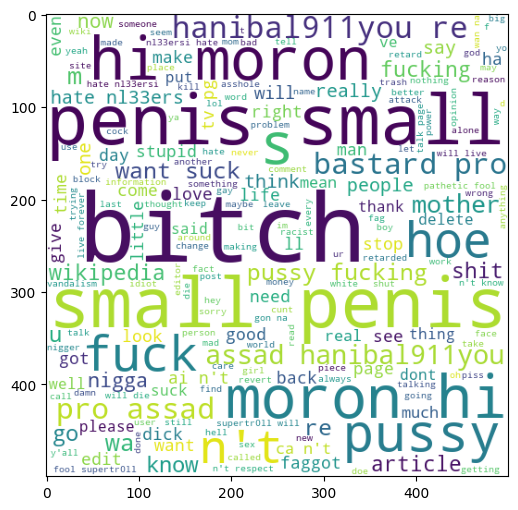

In [14]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
profane_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(profane_wc)
plt.show()

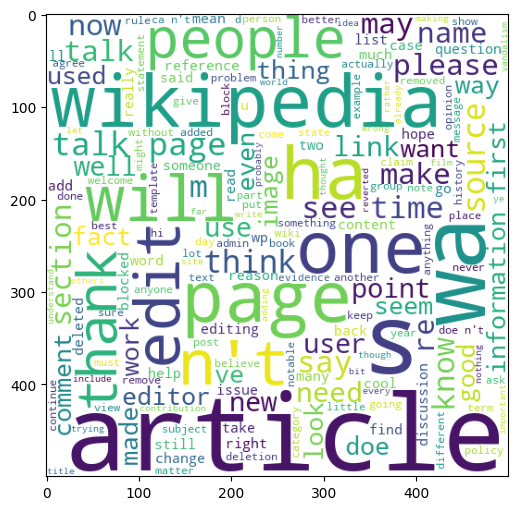

In [15]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
sane_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(sane_wc)
plt.show()

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(stop_words='english', ngram_range=(1,5))
# tfidf = TfidfVectorizer(max_features=3000)
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5)

In [17]:
# X = tfidf.fit_transform(df['transformed_text']).toarray()
# y = df['target'].values

In [18]:
from sklearn.model_selection import train_test_split

X = df['transformed_text']
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=testTrainSplit, random_state=2)

X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

In [20]:
clfs = {
    # 'svc': SVC(kernel='sigmoid', gamma=1.0),
    # 'knc': KNeighborsClassifier(),
    # 'mnb': MultinomialNB(),
    # 'dtc': DecisionTreeClassifier(max_depth=5),
    # 'lrc': LogisticRegression(solver='liblinear', penalty='l1'),
    # 'rfc': RandomForestClassifier(n_estimators=50, random_state=2),
    # 'abc': AdaBoostClassifier(n_estimators=50, random_state=2),
    # 'bc': BaggingClassifier(n_estimators=50, random_state=2),
    # 'etc': ExtraTreesClassifier(n_estimators=50, random_state=2),
    # 'gbdt': GradientBoostingClassifier(n_estimators=50, random_state=2),
    # 'xgb': XGBClassifier(n_estimators=50, random_state=2),
    'hard-vote': VotingClassifier(
        estimators=[
            ('mnb', MultinomialNB()),
            ('rfc', RandomForestClassifier(n_estimators=50, random_state=2)),
            ('xgb', XGBClassifier(n_estimators=50, random_state=2))
        ],
        voting='hard'
    )
}

In [21]:
from sklearn.metrics import accuracy_score, precision_score
import os.path
import pickle

def train_classifier(name, clfs, X_train, y_train, X_test, y_test):
    directory = f"./models/{modelToUse}"

    if not os.path.exists(directory):
        os.makedirs(directory)

    file = f"{directory}/{solution}-{name}.pkl"
    
    if usePretrainedModel == True and os.path.exists(file):
        with open(file, "rb") as f:
            clfs = pickle.load(f)
    else:
        clfs.fit(X_train, y_train)
        with open(file, "wb") as f:
            pickle.dump(clfs, f)
    
    y_preds = clfs.predict(X_test)
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    return accuracy, precision

In [22]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    curr_acc, curr_prec = train_classifier(name, clf, X_train, y_train, X_test, y_test)
    print()
    print(f"For: {name}")
    print(f"Accuarcy: {curr_acc}")
    print(f"Precision: {curr_prec}")

    accuracy_scores.append(curr_acc)
    precision_scores.append(curr_prec)


For: hard-vote
Accuarcy: 0.929
Precision: 0.950354609929078


In [23]:
def check_profanity(text):
    txt = tfidf.transform([text])
    
    for name, clf in clfs.items():
        prediction = clf.predict(txt)
        prediction = 'not-profane' if prediction == 0 else 'profane'
        print(f"{name} thinks '{text}' -> {prediction}")
        print("="*40)


testData = ["Hi Bruv, Hope you are doing well", "Love this product", "She's a hoe", 'Suck water from bottle', "write the article ibtch", "Idiot, A cup of cum for you! DRINK IT ALL PLZ", "A cup of cum for you! DRINK IT ALL PLZ"]

for text in testData:
    check_profanity(text)

hard-vote thinks 'Hi Bruv, Hope you are doing well' -> not-profane
hard-vote thinks 'Love this product' -> not-profane
hard-vote thinks 'She's a hoe' -> profane
hard-vote thinks 'Suck water from bottle' -> profane
hard-vote thinks 'write the article ibtch' -> not-profane
hard-vote thinks 'Idiot, A cup of cum for you! DRINK IT ALL PLZ' -> profane
hard-vote thinks 'A cup of cum for you! DRINK IT ALL PLZ' -> not-profane
